In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras import activations
from tensorflow.python.keras.utils.np_utils import to_categorical

## Exercise 2

#### Load data

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train / 255
y_train = to_categorical(y_train)
input_size = 28 * 28
x_train = x_train.reshape((x_train.shape[0], input_size))

#### Custom Dense layer

In [3]:
class OurDense(tf.keras.layers.Layer):
    def __init__(self, units, activation):
        super(OurDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.weight_mat = self.add_weight(
            "weight_mat",
            shape=(int(input_shape[-1]), self.units),
            initializer=initializers.glorot_normal(),
        )
        self.bias = self.add_weight(
            "bias", shape=(self.units,), initializer=initializers.constant()
        )

    def call(self, inputs, **kwargs):
        return self.activation(tf.matmul(inputs, self.weight_mat) + self.bias)


model = keras.Sequential(
    [
        OurDense(units=32, activation=activations.relu),
        OurDense(units=10, activation=activations.softmax),
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 2s 918us/step - loss: 0.5831 - accuracy: 0.8379
Epoch 2/2
1875/1875 [==============================] - 1s 728us/step - loss: 0.2062 - accuracy: 0.9398


#### Custom Sampling Layer


In [4]:
kl_weight = tf.Variable(1.0)


class SamplingLayer(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        mu = inputs[0]
        log_var = inputs[1]
        kl_loss = (
            -tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            )
            / 2
        )

        self.add_loss(
            kl_weight
            * kl_loss
            / 784  # scale the KL to a magnitude comparable to the MSE
        )

        # generate the random noise
        eps = tf.random.normal(tf.shape(mu))

        return mu + eps * tf.exp(log_var / 2)

In [5]:
latent_dim = 32
hidden_dim = 512
sample_dim = 784

input = layers.Input(shape=(sample_dim,))

# common encoder layers
ll = OurDense(hidden_dim, activation=activations.relu)(input)

# separate heads for mean and standard deviation
latent_mean = OurDense(latent_dim, activations.linear)(ll)
latent_log_std = OurDense(latent_dim, activations.linear)(ll)

In [6]:
# note that the input is a list of two layers
latent_code = SamplingLayer()((latent_mean, latent_log_std))

# decoder layers
x = OurDense(hidden_dim, activations.relu)(latent_code)
output = OurDense(sample_dim, activations.linear)(x)

In [7]:
model = keras.Model(input, output)
model.compile(
    loss="mse",
    optimizer="adam",
)

model.fit(x_train, x_train, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0576
Epoch 2/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0445


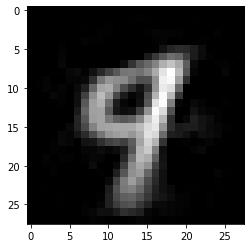

In [8]:
reconstruction = model.predict(x_train[[4], :])
reconstruction = np.clip(reconstruction, 0, 1).reshape((28, -1))
plt.imshow(reconstruction, cmap="gray")

#### Custom Callback

In [9]:
class KlAnnealingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_start, duration_epochs, variable):
        super(KlAnnealingCallback, self).__init__()
        self.epoch_start = epoch_start
        self.duration_epochs = duration_epochs
        self.variable = variable

    def on_train_begin(self, logs=None):
        self.variable.assign(0)

    def on_epoch_begin(self, epoch, logs=None):
        epoch += 1
        if epoch < self.epoch_start:
            print(f"epoch {epoch} is lower than starting epoch {self.epoch_start}")
        else:
            new_weight = min((epoch - self.epoch_start) / self.duration_epochs, 1)
            self.variable.assign(new_weight)
            print(f"kl weight is {new_weight} at epoch {epoch}")


input = layers.Input(shape=(sample_dim,))
ll = layers.Dense(hidden_dim, activations.relu)(input)
latent_mean = layers.Dense(latent_dim, activations.linear)(ll)
latent_log_std = layers.Dense(latent_dim, activations.linear)(ll)

latent_code = SamplingLayer()((latent_mean, latent_log_std))
x = layers.Dense(hidden_dim, activations.relu)(latent_code)
output = layers.Dense(sample_dim, activations.linear)(x)

model = keras.Model(input, output)
model.compile(
    loss="mse",
    optimizer="adam",
)

model.fit(
    x_train,
    x_train,
    epochs=20,
    callbacks=[
        KlAnnealingCallback(epoch_start=4, duration_epochs=8, variable=kl_weight)
    ],
)

Epoch 1/20
epoch 1 is lower than starting epoch 4
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0266
Epoch 2/20
epoch 2 is lower than starting epoch 4
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0118
Epoch 3/20
epoch 3 is lower than starting epoch 4
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102
Epoch 4/20
kl weight is 0.0 at epoch 4
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0095
Epoch 5/20
kl weight is 0.125 at epoch 5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0217
Epoch 6/20
kl weight is 0.25 at epoch 6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0268
Epoch 7/20
kl weight is 0.375 at epoch 7
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0309
Epoch 8/20
kl weight is 0.5 at epoch 8
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0337
Epoch 9/20
kl weight is 0.625 at epoch 9
1875/1875 [======================

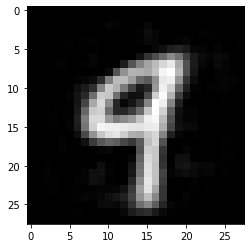

In [10]:
reconstruction = model.predict(x_train[[4], :])
reconstruction = np.clip(reconstruction, 0, 1).reshape((28, -1))
plt.imshow(reconstruction, cmap="gray")